In [1]:
import nibabel as nib
import numpy as np
from skimage import morphology, measure
from scipy.ndimage import binary_closing, binary_opening
import os

Volume shape: (512, 512, 216)


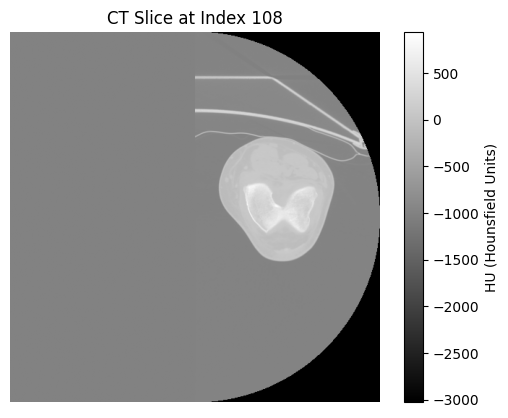

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the CT scan
nifti_img = nib.load('../left_knee.nii.gz')  # replace with actual path
volume = nifti_img.get_fdata()

print("Volume shape:", volume.shape)

# Choose a middle slice along one axis (typically axial slices)
slice_index = volume.shape[2] // 2
slice_img = volume[:, :, slice_index]

# Display the slice
plt.imshow(slice_img.T, cmap='gray', origin='lower')
plt.title(f'CT Slice at Index {slice_index}')
plt.axis('off')
plt.colorbar(label='HU (Hounsfield Units)')
plt.show()

In [10]:
def load_nii(path):
    """Loads a NIfTI image and returns image data and affine matrix"""
    img = nib.load(path)
    return img.get_fdata(), img.affine, img.header

In [11]:
def save_nii(data, affine, header, path):
    """Saves image data to a NIfTI file"""
    nib.save(nib.Nifti1Image(data.astype(np.uint8), affine, header), path)


In [12]:
def segment_bone(ct_volume, threshold=300):
    """
    Segments bone based on intensity thresholding.
    Typical CT Hounsfield values: bone > 300 HU
    """
    bone_mask = ct_volume > threshold  # bone = high intensity
    bone_mask = morphology.remove_small_objects(bone_mask.astype(bool), min_size=1000)
    bone_mask = morphology.remove_small_holes(bone_mask, area_threshold=1000)
    return bone_mask.astype(np.uint8)

In [13]:
def keep_largest_components(mask, num_components=2):
    """Keeps the largest N connected components — expected femur & tibia"""
    labeled = measure.label(mask)
    props = measure.regionprops(labeled)
    props = sorted(props, key=lambda x: x.area, reverse=True)
    output_mask = np.zeros_like(mask)

    for i in range(min(num_components, len(props))):
        output_mask[labeled == props[i].label] = 1

    return output_mask

In [14]:
if __name__ == "__main__":
    # Step 1: Load CT scan
    input_path = "left_knee.nii.gz" 
    ct_volume, affine, header = load_nii(input_path)

    # Step 2: Segment bone
    raw_bone_mask = segment_bone(ct_volume, threshold=300)

    # Step 3: Keep only femur & tibia
    final_bone_mask = keep_largest_components(raw_bone_mask, num_components=2)

    # Step 4: Save result
    os.makedirs("masks", exist_ok=True)
    output_path = "masks/original_mask.nii.gz"
    save_nii(final_bone_mask, affine, header, output_path)

    print("Segmentation complete. Mask saved at:", output_path)

Segmentation complete. Mask saved at: masks/original_mask.nii.gz


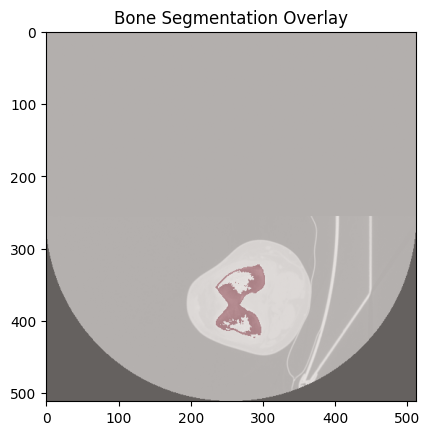

In [15]:
import matplotlib.pyplot as plt
plt.imshow(ct_volume[:, :, ct_volume.shape[2]//2], cmap='gray')
plt.imshow(final_bone_mask[:, :, ct_volume.shape[2]//2], alpha=0.4, cmap='Reds')
plt.title("Bone Segmentation Overlay")
plt.show()


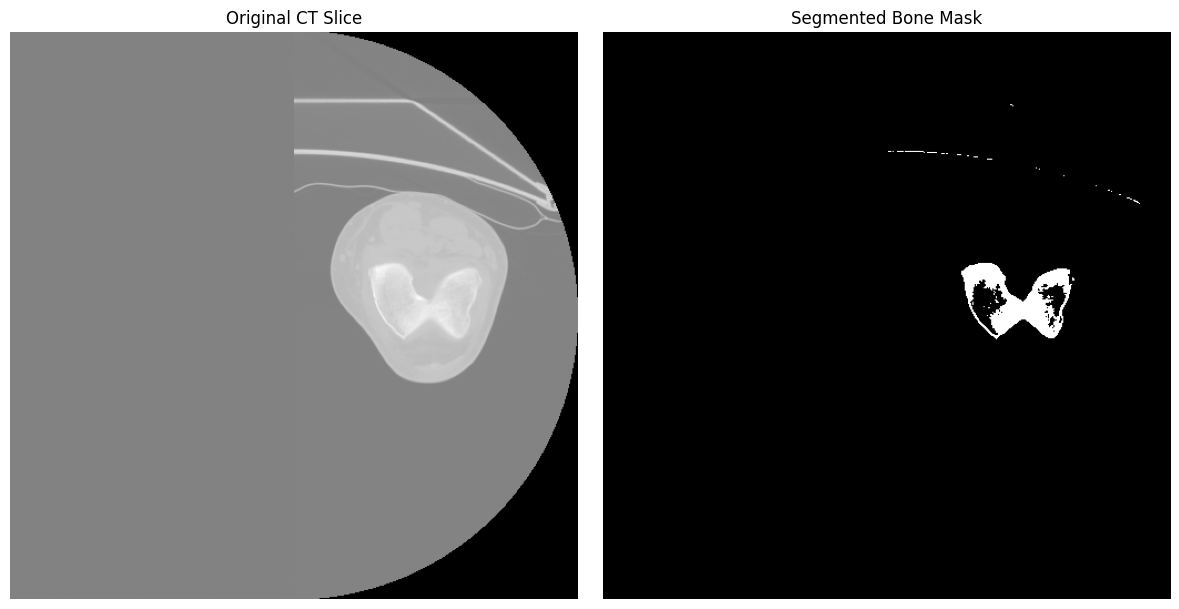

In [16]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load the NIfTI file
img = nib.load('left_knee.nii.gz')  # Replace with your actual file path
volume = img.get_fdata()

# Choose a slice number you want to analyze (e.g., middle slice)
slice_index = volume.shape[2] // 2  # You can adjust this

# Get the original slice
original_slice = volume[:, :, slice_index]

# Apply threshold to segment bone (HU > 300)
threshold = 300
segmented_slice = (original_slice > threshold).astype(np.uint8)

# Plot side by side
plt.figure(figsize=(12, 6))

# Original slice
plt.subplot(1, 2, 1)
plt.imshow(original_slice.T, cmap='gray', origin='lower')
plt.title('Original CT Slice')
plt.axis('off')

# Segmented slice
plt.subplot(1, 2, 2)
plt.imshow(segmented_slice.T, cmap='gray', origin='lower')
plt.title('Segmented Bone Mask')
plt.axis('off')

plt.tight_layout()
plt.show()
